<a href="https://colab.research.google.com/github/QueeneDelmarva/Thesis/blob/main/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Thesis Code**

## **Requirements**

In [54]:
!pip install graphviz

## **Importing Libraries**

In [49]:
# Connect to Gdrive
from google.colab import drive

# Connect to Gsheets
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import auth
from google.auth import default

# Preprocessing
import time
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Generate Misspellings
import random
import string

#Visualize the Trie
from graphviz import Digraph
from IPython.display import SVG, display

# Performance Evaluation
import numpy as np

## **Connecting to Gdrive**

In [50]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Connecting to GSheets**

In [51]:
# Define the scope and create the credentials using the file in your Google Drive
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('/content/drive/MyDrive/skripsi-394804-a98ea9715aa4.json', scope)

# Authenticate with gspread
client = gspread.authorize(creds)

# Open the Google Sheet by its title or URL
spreadsheet_key = '1RlZ8-XwwEueuCAq4nXGwq3ZmPDE-_0gP3PsroKeNFGo'
sheet = client.open_by_key(spreadsheet_key).sheet1 # Original_Data

# Open the train_data Google Sheet by its title or URL for writing
train_data_sheet = client.open_by_key(spreadsheet_key).worksheet('train_data')
test_data_sheet = client.open_by_key(spreadsheet_key).worksheet('test_data')
new_data_sheet = client.open_by_key(spreadsheet_key).worksheet('new_data')

## Read the data from the Gsheets
# 1. Read individual cells
# cell_value = sheet.cell(3, 5).value
# print(cell_value)

# cell_value = train_data_sheet.cell(3, 1).value
# print(cell_value)

# # 2. Read all values from the first worksheet
# data = sheet.get_all_values()

# # Print the data
# for row in data:
#     print(row)

## **Preprocessing Data**

In [52]:
# Cleaning the data
class DataPreprocessor:
    def __init__(self):
        nltk.download('stopwords')
        nltk.download('punkt')
        self.stop_words = set(stopwords.words('english'))

    def preprocess_text(self, text):
        cleaned_text = re.sub(r'[^a-zA-Z0-9\s/]', '', text).lower()
        tokens = word_tokenize(cleaned_text)

        # Remove stopwords
        filtered_tokens = [word for word in tokens if word not in self.stop_words]

        print("Filtered Tokens:", filtered_tokens)

        # Count repeated words and remove consecutive duplicate words
        cleaned_tokens = [filtered_tokens[0]]  # Initialize with the first word
        repeated_word_count = 0
        for i in range(1, len(filtered_tokens)):
            if filtered_tokens[i] != filtered_tokens[i - 1]:
                cleaned_tokens.append(filtered_tokens[i])
            else:
                repeated_word_count += 1

        preprocessed_text = ' '.join(cleaned_tokens)
        return preprocessed_text, repeated_word_count

# Read values from columns 1 to 5 in the sheet
# all_values = []
# start_column = 1  # Start from column 1
# end_column = 5    # End at column 5 (inclusive)

# Example usage
preprocessor = DataPreprocessor()

# Read values from columns 1 to 5
start_row = 1  # Start from row 1
end_row = sheet.row_count  # End at the last row
start_column = 1  # Start from column 1
end_column = 5    # End at column 5 (inclusive)

values_to_process = [cell.value for cell in sheet.range(start_row, start_column, end_row, end_column)]

# Combine all values into a single string
combined_text = ' '.join(values_to_process)

# Preprocess the combined text
preprocessed_text, repeated_word_count = preprocessor.preprocess_text(combined_text)

# Write preprocessed words to the 'train_data' sheet
row_index = 1  # Start writing from row 1
column_index = 1  # Start writing from column 1

# preprocessed_words = preprocessed_text.split()  # Split the preprocessed text into words
# for word in preprocessed_words:
#     train_data_sheet.update_cell(row_index, column_index, word)
#     row_index += 1  # Move to the next row
#     time.sleep(2) # Introduce a delay of 2 second between requests

# print("Preprocessed Text:", preprocessed_text)
# print("Repeated Word Count:", repeated_word_count)

# print("Preprocessed words written to 'train_data' sheet.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Filtered Tokens: ['date', 'subject', 'content', '01/08/2022', 'acam', 'occ', 'fuel', 'sinops', 'fuel', 'release', 'request', 't7977', '828n', 'mon', '01', 'aug', '2022', '0650z', '1450', 'lt', 'arrival', 'handling', 'request', 'acam', 'fuel', 'release', 'request', 'kindly', 'confirm', 'reply', 'email', 'station', 'wssl', 'xsp', 'wssl', 'flight', 'aircraft', 'arcid', 't7977', 'type', 't7977', 'icao', 'glf4', 'mtow', '74000', 'lb', 'fire', 'cat', 'seat', 'cap', '12', 'inbound', 'flight', 'flt', 'type', 'g', 'private', 'flight', '828n', 'wiii', 'cgk', 'wiii', 'etd', 'mon', '01', 'aug', '2022', '0530z', '1230', 'lt', 'wssl', 'xsp', 'wssl', 'eta', 'mon', '01', 'aug', '2022', '0650z', '1450', 'lt', 'crew', '0', 'pax', '0', 'outbound', 'flight', 'flt', 'type', 'g', 'private', 'flight', '512r', 'wssl', 'xsp', 'wssl', 'etd', 'mon', '01', 'aug', '2022', '0800z', '1600', 'lt', 'wiii', 'cgk', 'wiii', 'eta', 'mon', '01', 'aug', '2022', '0943z', '1643', 'lt', 'crew', '0', 'pax', '8', 'fuel', 'releas

### **Generate Misspellings**

In [53]:
# Get the unique training data from the 'train_data' worksheet
all_words = train_data_sheet.col_values(1)[1:]  # Assuming the words are in column A (excluding header)

unique_train_data = []
seen_words = set()

for word in all_words:
    if word not in seen_words:
        unique_train_data.append(word)
        seen_words.add(word)

print("Unique training data:", unique_train_data)

# Function to generate misspelling
def generate_misspelling(word, typo_type):
    if typo_type == "omit" and len(word) > 1:
        idx = random.randint(0, len(word) - 1)
        return word[:idx] + word[idx + 1:]
    elif typo_type == "substitute":
        idx = random.randint(0, len(word) - 1)
        substitute_letter = random.choice("abcdefghijklmnopqrstuvwxyz")
        return word[:idx] + substitute_letter + word[idx + 1:]
    elif typo_type == "add":
        idx = random.randint(0, len(word))
        added_letter = random.choice("abcdefghijklmnopqrstuvwxyz")
        return word[:idx] + added_letter + word[idx:]
    elif typo_type == "soundalike":
        vowels = "aeiou"
        return ''.join([c if c not in vowels else random.choice(vowels) for c in word])
    elif typo_type == "typo":
        idx = random.randint(0, len(word) - 1)
        return word[:idx] + word[idx] + word[idx:]
    else:  # typo_type == "mixed"
        typo_types = ["omit", "substitute", "add", "soundalike", "typo"]
        random.shuffle(typo_types)
        misspelled_word = word
        for t in typo_types:
            misspelled_word = generate_misspelling(misspelled_word, t)
        return misspelled_word

# Open the 'test_data' worksheet for reading
data = test_data_sheet.get_all_values()

# Define the starting row number
starting_row = 3843

# Generate test data with every type of misspelling for each word in unique_train_data
test_data_with_all_types = []
for word in unique_train_data:
    for typo_type in ["omit", "substitute", "add", "soundalike", "typo", "mixed"]:
        misspelled_word = generate_misspelling(word, typo_type)
        # test_data_with_all_types.append((word, misspelled_word, typo_type))


# Write the test data into the 'test_data' worksheet, starting from the defined row
for idx, (original_word, misspelled_word, mistake_type) in enumerate(test_data_with_all_types):
    if idx >= starting_row - 1:  # Adjusting for 0-based indexing
        # test_data_sheet.append_row([original_word, misspelled_word, mistake_type])
        # print(f"Appended row {idx + 1}: {original_word} | {misspelled_word} | {mistake_type}")
        time.sleep(2)  # Add a 2-second delay between write requests

print("Test data has been written to the 'test_data' worksheet.")

# Print the contents of the 'test_data' worksheet
# print("Contents of 'test_data' worksheet:")
# for row in data:
#     print(row)

Unique training data: ['acam', 'fuel', 'release', 'request', 't7977', '828n', 'mon', '1', 'aug', '2022', '0650z', '1450', 'lt', 'arrival', 'handling', 'kindly', 'confirm', 'reply', 'email', 'station', 'wssl', 'xsp', 'flight', 'aircraft', 'arcid', 'type', 'icao', 'glf4', 'mtow', '74000', 'lb', 'fire', 'cat', 'seat', 'cap', '12', 'inbound', 'flt', 'g', 'private', 'wiii', 'cgk', 'etd', '0530z', '1230', 'eta', 'crew', '0', 'pax', 'outbound', '512r', '0800z', '1600', '0943z', '1643', '8', 'please', 'issue', 'quantity', 'fbo', 'universal', 'aviation', 'singaporeuniversalaviationaero', 'phone', '6564844878', '01/08/2022', 'kee', 'yong', 'goh', 'occ', 'dear', 'ops', 'thank', 'arranged', 'requested', 'number', 'is/are', 'referenced', '40002020', 'consider', 'us', 'ground', 'services', 'requirements', 'dont', 'hesitate', 'ask', 'would', 'like', 'information', 'note', 'world', 'extended', 'system', 'maintenance', 'window', 'starting', 'today', 'friday', 'july', '29', '2300hrs', 'est', 'sunday', '

## **Radix Trie**

### Visualizing Radix Trie

In [10]:
class TrieNodeGraphviz:
    def __init__(self, char):
        self.char = char
        self.children = {}

['release', 'relay', 'rely', 'reload', 'rest', 'restore', 'restart']


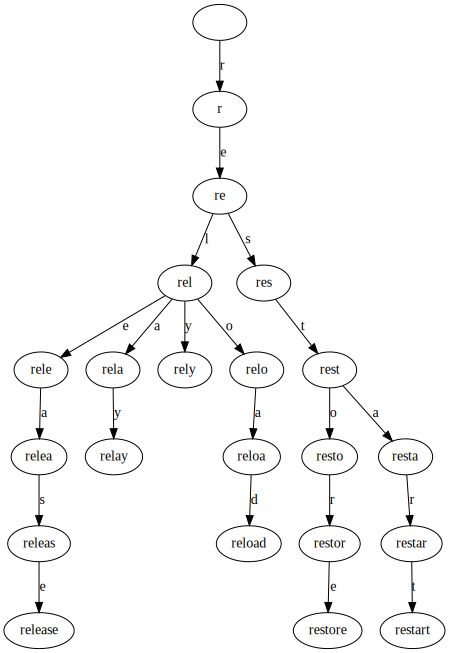

In [11]:
def visualize_radix_trie(node, dot, prefix=""):
    if node.char:
        dot.node(prefix, shape="ellipse", label=prefix)
    for char, child_node in node.children.items():
        child_prefix = prefix + char
        dot.edge(prefix, child_prefix, label=char)
        visualize_radix_trie(child_node, dot, child_prefix)

def run_visual_trie():
    train_data_sheet = client.open_by_key(spreadsheet_key).worksheet('train_data')

    # Fetch data from the train_data worksheet
    train_data = train_data_sheet.get_all_values()

    # for i, row in enumerate(train_data):
    #     if i >= 7:  # Print the first 3 words
    #         break
    #     print(row[0])  # Assuming the term is in the first column

    # From train_data worksheet
    dictonary = ["release","relay","rely","reload","rest","restore","restart"]
    print(dictonary)

    # Build and visualize the radix trie
    radix_trie = TrieNodeGraphviz("")  # Create a dummy root node

    # for term in train_data[:7]:  # Use only the first 3 words
    #     term_str = term[0]  # Assuming your term is in the first column of the worksheet
    for term in dictonary:
        node = radix_trie
        # for char in term_str:
        for char in term:
            if char not in node.children:
                node.children[char] = TrieNodeGraphviz(char)
            node = node.children[char]

    dot = Digraph()
    visualize_radix_trie(radix_trie, dot)

    dot.format = "svg"
    svg_content = dot.pipe().decode("utf-8")
    display(SVG(svg_content))

run_visual_trie()

### Prefix, Suffix, Similarity Score

In [72]:
class RadixTrieNode:
    def __init__(self):
        self.children = {}
        self.is_end_of_word = False

In [73]:
class RadixTrie:
    def __init__(self):
        self.root = RadixTrieNode()

    def insert(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                node.children[char] = RadixTrieNode()
            node = node.children[char]
        node.is_end_of_word = True

    def search_prefixes(self, prefix):
        node = self.root
        for char in prefix:
            if char not in node.children:
                return []
            node = node.children[char]
        return self._collect_words_with_prefix(node, prefix)

    def search_suffixes(self, suffix):
        node = self.root
        for char in reversed(suffix):
            if char not in node.children:
                return []
            node = node.children[char]
        return self._collect_words_with_suffix(node, suffix)

    def _collect_words_with_prefix(self, node, prefix):
        result = []
        if node.is_end_of_word:
            result.append(prefix)
        for char, child_node in node.children.items():
            child_words = self._collect_words_with_prefix(child_node, prefix + char)
            result.extend(child_words)
        return result

    def _collect_words_with_suffix(self, node, suffix):
        result = []
        if node.is_end_of_word:
            result.append(suffix)
        for char, child_node in node.children.items():
            child_words = self._collect_words_with_suffix(child_node, char + suffix)
            result.extend(child_words)
        return result

In [74]:
def levenshtein_distance(s1, s2):
    # """Calculate Levenshtein distance between two strings."""
    matrix = np.zeros((len(s1) + 1, len(s2) + 1))
    for i in range(len(s1) + 1):
        matrix[i][0] = i
    for j in range(len(s2) + 1):
        matrix[0][j] = j

    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1
            matrix[i][j] = min(matrix[i - 1][j] + 1, matrix[i][j - 1] + 1, matrix[i - 1][j - 1] + cost)

    return matrix[len(s1)][len(s2)]

def calculate_prefix_score(data, search_word):
    prefix_score = {}
    for row in data:
        term = row[0]
        if len(term) >= 1:
            common_prefix = 0
            for i in range(1, min(len(term), len(search_word)) + 1):
                if term[:i] == search_word[:i]:
                    common_prefix = i
                else:
                    break
            if common_prefix >= 1:
                prefix_score[term] = common_prefix
    return prefix_score

def calculate_suffix_score(data, search_word):
    suffix_score = {}
    for row in data:
        term = row[0]
        if len(term) >= 2:
            common_suffix = 0
            for i in range(2, min(len(term), len(search_word)) + 1):
                if term[-i:] == search_word[-i:]:
                    common_suffix = i
                else:
                    break
            if common_suffix >= 2:
                suffix_score[term] = common_suffix
    return suffix_score

def calculate_similarity_score(t, s):
    lcs_length = levenshtein_distance(t, s)
    similarity_score = (2 * lcs_length) / (len(t) + len(s))
    return similarity_score

def calculate_sim_score(t, s):
    similarity_score = calculate_similarity_score(t, s)
    if t[0] != s[0]:
        return similarity_score
    else:
        return 1.1 * similarity_score

In [75]:
def run_radix_trie():
    # Assuming train_data is a list of terms obtained from your Google Sheets
    train_data = train_data_sheet.get_all_values()

    radix_trie = RadixTrie()
    for term in train_data:
        radix_trie.insert(term[0])  # Assuming the term is in the first column

    search_word = input("Enter a word: ")

    choice = input("Do you want to calculate (1) prefix scores or (2) suffix scores? ")

    if choice == '1':
        prefix_scores = calculate_prefix_score(train_data, search_word)
        print("Prefix Scores:")
        print("Word:", search_word)
        print("Suggestions:")
        sorted_suggestions = sorted(prefix_scores.items(), key=lambda x: x[1], reverse=True)
        for suggestion, score in sorted_suggestions:
            similarity_score = calculate_sim_score(suggestion, search_word)
            print(f"'{suggestion}': Prefix Score: {score}, Similarity Score: {similarity_score}")
    elif choice == '2':
        suffix_scores = calculate_suffix_score(train_data, search_word)
        print("Suffix Scores:")
        print("Word:", search_word)
        print("Suggestions:")
        sorted_suggestions = sorted(suffix_scores.items(), key=lambda x: x[1], reverse=True)
        for suggestion, score in sorted_suggestions:
            similarity_score = calculate_sim_score(suggestion, search_word)
            print(f"'{suggestion}': Suffix Score: {score}, Similarity Score: {similarity_score}")
    else:
        print("Invalid choice.")

run_radix_trie()

Enter a word: aa
Do you want to calculate (1) prefix scores or (2) suffix scores? 2
Suffix Scores:
Word: aa
Suggestions:
'waa': Suffix Score: 2, Similarity Score: 0.4
'waaa': Suffix Score: 2, Similarity Score: 0.6666666666666666


## **Hashmap-based Trie**

### Visualizing Radix Trie

In [76]:
class HashmapTrieNode:
    def __init__(self):
        self.children = {}
        self.words = {}

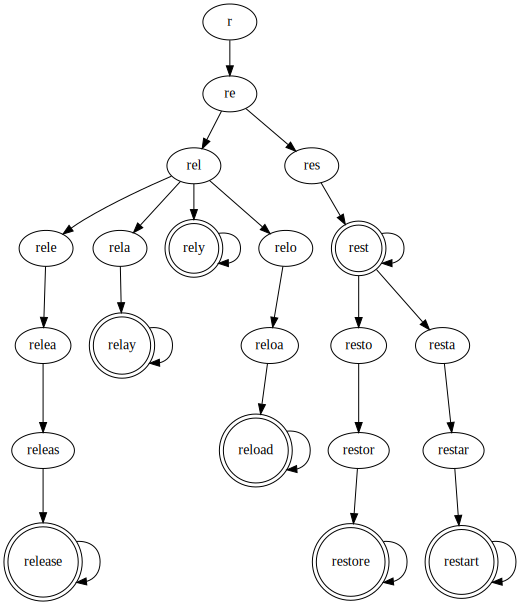

In [60]:
class HashmapTrie:
    def __init__(self):
        self.root = HashmapTrieNode()

    def insert(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                node.children[char] = HashmapTrieNode()
            node = node.children[char]
        node.words[word] = True

def visualize_hashmap_trie(node, dot, parent_node_name=None):
    if parent_node_name is not None:
        dot.node(parent_node_name, parent_node_name)

    for char, child_node in node.children.items():
        child_node_name = parent_node_name + char if parent_node_name else char
        dot.node(child_node_name, char)
        if parent_node_name is not None:
            dot.edge(parent_node_name, child_node_name)
        visualize_hashmap_trie(child_node, dot, child_node_name)

    for word in node.words:
        dot.node(word, word, shape="doublecircle")
        dot.edge(parent_node_name, word)

def run_visual_hashmaptrie():
    trie = HashmapTrie()

    # From train_data worksheet
    dictionary = ["release","relay","rely","reload","rest","restore","restart"]
    for word in dictionary:
        trie.insert(word)

    dot = Digraph()
    visualize_hashmap_trie(trie.root, dot)

    dot.format = "svg"
    svg_content = dot.pipe().decode("utf-8")
    display(SVG(svg_content))

run_visual_hashmaptrie()

### Prefix, Suffix, Similarity Score

In [66]:
class HashmapTrieNode:
    def __init__(self):
        self.children = {}
        self.words = {}

In [67]:
class HashmapTrie:
    def __init__(self):
        self.root = HashmapTrieNode()

    def insert(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                node.children[char] = HashmapTrieNode()
            node = node.children[char]
        node.words[word] = True

    def search_prefixes(self, prefix):
        node = self.root
        for char in prefix:
            if char not in node.children:
                return []
            node = node.children[char]
        return self._collect_words_with_prefix(node, prefix)

    def search_suffixes(self, suffix):
        node = self.root
        for char in reversed(suffix):
            if char not in node.children:
                return []
            node = node.children[char]
        return self._collect_words_with_suffix(node, suffix)

    def _collect_words_with_prefix(self, node, prefix):
        result = []
        result.extend(node.words.keys())
        for char, child_node in node.children.items():
            child_words = self._collect_words_with_prefix(child_node, prefix + char)
            result.extend(child_words)
        return result

    def _collect_words_with_suffix(self, node, suffix):
        result = []
        result.extend(node.words.keys())
        for char, child_node in node.children.items():
            child_words = self._collect_words_with_suffix(child_node, char + suffix)
            result.extend(child_words)
        return result

In [68]:
def levenshtein_distance(s1, s2):
    # """Calculate Levenshtein distance between two strings."""
    matrix = np.zeros((len(s1) + 1, len(s2) + 1))
    for i in range(len(s1) + 1):
        matrix[i][0] = i
    for j in range(len(s2) + 1):
        matrix[0][j] = j

    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1
            matrix[i][j] = min(matrix[i - 1][j] + 1, matrix[i][j - 1] + 1, matrix[i - 1][j - 1] + cost)

    return matrix[len(s1)][len(s2)]

def calculate_prefix_score(data, search_word):
    prefix_score = {}
    for row in data:
        term = row[0]
        if len(term) >= 1:
            common_prefix = 0
            for i in range(1, min(len(term), len(search_word)) + 1):
                if term[:i] == search_word[:i]:
                    common_prefix = i
                else:
                    break
            if common_prefix >= 1:
                prefix_score[term] = common_prefix
    return prefix_score

def calculate_suffix_score(data, search_word):
    suffix_score = {}
    for row in data:
        term = row[0]
        if len(term) >= 2:
            common_suffix = 0
            for i in range(2, min(len(term), len(search_word)) + 1):
                if term[-i:] == search_word[-i:]:
                    common_suffix = i
                else:
                    break
            if common_suffix >= 2:
                suffix_score[term] = common_suffix
    return suffix_score

def calculate_similarity_score(t, s):
    lcs_length = levenshtein_distance(t, s)
    similarity_score = (2 * lcs_length) / (len(t) + len(s))
    return similarity_score

def calculate_sim_score(t, s):
    similarity_score = calculate_similarity_score(t, s)
    if t[0] != s[0]:
        return similarity_score
    else:
        return 1.1 * similarity_score

In [71]:
def run_hashmap_trie():
    #dictionary = ["diffusion", "effusion", "perfusion"]

    # Assuming train_data is a list of terms obtained from your Google Sheets
    train_data = train_data_sheet.get_all_values()

    hashmap_trie = HashmapTrie()
    for term in train_data:
        hashmap_trie.insert(term[0])

    search_word = input("Enter a word: ")

    choice = input("Do you want to calculate (1) prefix scores or (2) suffix scores? ")

    if choice == '1':
        prefix_scores = calculate_prefix_score(train_data, search_word)
        print("Prefix Scores:")
        print("Word:", search_word)
        print("Suggestions:")
        sorted_suggestions = sorted(prefix_scores.items(), key=lambda x: x[1], reverse=True)
        for suggestion, score in sorted_suggestions:
            similarity_score = calculate_sim_score(suggestion, search_word)
            print(f"'{suggestion}': Prefix Score: {score}, Similarity Score: {similarity_score}")
    elif choice == '2':
        suffix_scores = calculate_suffix_score(train_data, search_word)
        print("Suffix Scores:")
        print("Word:", search_word)
        print("Suggestions:")
        sorted_suggestions = sorted(suffix_scores.items(), key=lambda x: x[1], reverse=True)
        for suggestion, score in sorted_suggestions:
            similarity_score = calculate_sim_score(suggestion, search_word)
            print(f"'{suggestion}': Suffix Score: {score}, Similarity Score: {similarity_score}")
    else:
        print("Invalid choice.")

run_hashmap_trie()

Enter a word: aa
Do you want to calculate (1) prefix scores or (2) suffix scores? 2
Suffix Scores:
Word: aa
Suggestions:
'waa': Suffix Score: 2, Similarity Score: 0.4
'waaa': Suffix Score: 2, Similarity Score: 0.6666666666666666


## **Performance Evaluation**

### Accuracy

In [45]:
import random

class AccuracyCalculator:
    def __init__(self, train_data, search_word, threshold):
        self.train_data = train_data
        self.search_word = search_word
        self.threshold = threshold

    def calculate_accuracy(self):
        correct_predictions = 0
        total_queries = len(self.train_data)

        for term in self.train_data:
            similarity_score = calculate_sim_score(term[0], self.search_word)
            if similarity_score >= self.threshold:
                correct_predictions += 1

        accuracy = correct_predictions / total_queries
        return accuracy

def run_accuracy_calculator():
    # Assuming train_data is a list of terms obtained from your Google Sheets
    train_data = train_data_sheet.get_all_values()

    # Adjust the sample_size based on your needs
    sample_size = 100  # For example, test accuracy on 100 randomly selected terms
    sampled_data = random.sample(train_data, sample_size)

    search_word = input("Enter a misspelled word: ")
    threshold = float(input("Enter the similarity score threshold: "))  # Adjust as needed

    accuracy_calculator = AccuracyCalculator(sampled_data, search_word, threshold)
    accuracy = accuracy_calculator.calculate_accuracy()

    print(f"Accuracy for '{search_word}': {accuracy:.2%}")

run_accuracy_calculator()


Enter a misspelled word: fuell
Enter the similarity score threshold: 0.7
Accuracy for 'fuell': 99.00%


### MMR

In [77]:
class MetricsCalculator:
    def __init__(self, train_data, search_word, threshold):
        self.train_data = train_data
        self.search_word = search_word
        self.threshold = threshold

    def calculate_metrics(self):
        total_queries = len(self.train_data)
        total_reciprocal_rank = 0
        correct_predictions = 0

        for term in self.train_data:
            similarity_score = calculate_sim_score(term[0], self.search_word)
            if similarity_score >= self.threshold:
                rank = self.train_data.index(term) + 1  # Adding 1 because of 0-indexing
                reciprocal_rank = 1 / rank if rank > 0 else 0
                total_reciprocal_rank += reciprocal_rank
                if term[0] == self.search_word:
                    correct_predictions += 1

        mean_reciprocal_rank = total_reciprocal_rank / total_queries
        return  mean_reciprocal_rank

def run_metrics_calculator():
    # Assuming train_data is a list of terms obtained from your Google Sheets
    train_data = train_data_sheet.get_all_values()

    # Adjust the sample_size and threshold based on your needs
    sample_size = 100  # For example, test on 100 randomly selected terms
    threshold = 0.7

    sampled_data = random.sample(train_data, sample_size)

    search_word = input("Enter a misspelled word: ")

    metrics_calculator = MetricsCalculator(sampled_data, search_word, threshold)
    mrr = metrics_calculator.calculate_metrics()

    print(f"MRR for '{search_word}': {mrr:.4f}")

run_metrics_calculator()

Enter a misspelled word: ful
MRR for 'ful': 0.0579


### Time

### Space

### Autocomplete (Live Update to Gsheets)


In [36]:
# Check for duplicates when inserting data to the train_data
class TrieNode:
    def __init__(self):
        self.children = {}
        self.is_end_of_word = False

class RadixTrie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                node.children[char] = TrieNode()
            node = node.children[char]
        node.is_end_of_word = True

    def find_words_with_prefix(self, prefix):
        node = self.root
        for char in prefix:
            if char not in node.children:
                return []
            node = node.children[char]
        return self._find_words_with_prefix(node, prefix)

    def _find_words_with_prefix(self, node, current_word):
        words = []
        if node.is_end_of_word:
            words.append(current_word)
        for char, child_node in node.children.items():
            words.extend(self._find_words_with_prefix(child_node, current_word + char))
        return words

def add_new_word_to_sheets(new_word):
    new_data_sheet.append_row([new_word])

# Load data from "train_data" Google Sheet and train RadixTrie
trie = RadixTrie()
train_data = train_data_sheet.get_all_values()
for row in train_data :
    word = row[0]
    trie.insert(word)

def add_new_word(new_word):
    trie.insert(new_word)
    add_new_word_to_sheets(new_word)  # Update the "new_data" Google Sheet with the new word

# Example usage
new_word = "grape"
add_new_word(new_word)

# Perform autocomplete as needed
prefix = "gr"
autocomplete_results = trie.find_words_with_prefix(prefix)
print("Autocomplete results for prefix '{}':".format(prefix))
print(autocomplete_results)


Autocomplete results for prefix 'gr':
['ground', 'green', 'grill', 'grilled', 'grape']
